In [1]:

import torch
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger

from lightning_module import LitUNetPlusPlus
from config import Config
from dataset import *
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)

from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False


Seed set to 99


In [2]:
cfg = Config(experiment_name = "Untrained")

In [10]:
experiment_folder = Path.cwd() / "models" / cfg.experiment_name
checkpoint = list(experiment_folder.glob("*.ckpt"))[0]
checkpoint

IndexError: list index out of range

## Run experiments

In [9]:
#cfg.source_domains = ["Cirrus", "Topcon", "Spectralis"]
#cfg.source_domains = ["Spectralis"]
#cfg.source_domains = ["Cirrus"]
#cfg.source_domains = ["Topcon"]
cfg.source_domains = ["Topcon", "Spectralis"]
ds = OCTDatasetPrep(cfg.train_dir, source_domains = cfg.source_domains)

# .get_datasets method handles splitting and which test set to use (a custom one that is split from
# the training set, or the official challenge testset)
train_data, val_data, test_data = ds.get_datasets(dataset_split=[0.7, 0.2, 0.1], use_official_testset=False)

# MakeDataset is a class that handles the actual dataset creation, including transforms
train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

Total dataset length:  2288
Training set: 1271
Validation set: 676
Test set: 341


In [ ]:
def run_experiment(
        source_domains, 
        experiment_name,
        batch_size=8,
        cfg=cfg):
    
    # DEFINE EXPERIMENT PARAMETERS
    ####################################################################################
    cfg.source_domains = source_domains


    cfg.experiment_name = experiment_name
    # experiment name defines the names for:
        # - the model
        # - the results file
        # - the wandb run
    ####################################################################################


    cfg.batch_size = batch_size
    cfg.epochs = 150

    # OCTDatasetPrep is a class that performs all necessary sorting and filtering of the dataset
    ds = OCTDatasetPrep(cfg.train_dir, source_domains = cfg.source_domains)

    # .get_datasets method handles splitting and which test set to use (a custom one that is split from
    # the training set, or the official challenge testset)
    train_data, val_data, test_data = ds.get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

    # MakeDataset is a class that handles the actual dataset creation, including transforms
    train_dataset = MakeDataset(train_data, cfg.train_transforms)
    val_dataset = MakeDataset(val_data, cfg.val_transforms)
    test_dataset = MakeDataset(test_data, cfg.test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)


    wandb_logger = WandbLogger(project="PracticalWorkinAI", 
                            name=cfg.experiment_name)


    # model is the actual model from segmentation_models_pytorch
    model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)

    # LitUnetPlusPlus is the lightning module defined in lightning_module.py
    unetpp = LitUNetPlusPlus(cfg, model, experiment_name=cfg.experiment_name)

    trainer = L.Trainer(max_epochs=cfg.epochs,
                        logger=wandb_logger,
                        default_root_dir=Path(cfg.default_root_dir),
                        log_every_n_steps=10,
                        deterministic=True,
                        callbacks=[cfg.checkpoint_callback, # saves best model based on validation loss, every 5 epochs
                                  cfg.lr_monitor, 
                                  #cfg.save_initial_model,
                                  cfg.early_stopping, # stops training if validation loss does not improve for 20 epochs
                                  cfg.aggregate_testing_results])


    #trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
    #trainer.test(unetpp, dataloaders=test_loader)
    #wandb.finish


In [ ]:
cfg.experiments = [
    {
        "source_domains": ["Spectralis", "Topcon", "Cirrus"],
        "experiment_name": "FullySupervised"
    },
    {
        "source_domains": ["Spectralis"],
        "experiment_name": "Spectralis"
    },
    {
        "source_domains": ["Topcon"],
        "experiment_name": "Topcon"
    },
    {
        "source_domains": ["Cirrus"],
        "experiment_name": "Cirrus"
    },
    {
        "source_domains": ["Spectralis", "Topcon"],
        "experiment_name": "SpectralisTopcon"
    }
]

for experiment in cfg.experiments:
    run_experiment(experiment["source_domains"], experiment["experiment_name"])

In [5]:
experiments = glob.glob(f"{cfg.model_path}/*")
experiments

['/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Supervised',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Topcon',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Cirrus',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon-Cirrus',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Topcon-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Cirrus-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon-Cirrus-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Cirrus']

### Test all models on the test set

In [ ]:
# OCTDatasetPrep is a class that performs all necessary sorting and filtering of the dataset
ds = OCTDatasetPrep(cfg.train_dir, source_domains = cfg.source_domains)

# .get_datasets method handles splitting and which test set to use (a custom one that is split from
# the training set, or the official challenge testset)
_, _, test_data = ds.get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

# MakeDataset is a class that handles the actual dataset creation, including transforms
test_dataset = MakeDataset(test_data, cfg.test_transforms)

test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)

In [7]:
test_all_models = True

if test_all_models:
    
    # find all folders with checkpoints
    experiments = [os.path.basename(exp) for exp in glob.glob(f"{cfg.model_path}/*")]

    for exp in experiments:
        
        checkpoint = list(Path(cfg.model_path / exp).glob("*.ckpt"))[0]

        wandb_logger = WandbLogger(project="PracticalWorkinAI", group="Testing", name=exp)

        model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, experiment_name=exp)
    
        trainer = L.Trainer(max_epochs=cfg.epochs,
                            logger=wandb_logger,
                            default_root_dir=Path(cfg.default_root_dir),
                            log_every_n_steps=10,
                            callbacks=[cfg.checkpoint_callback, # saves best model based on validation loss, every 5 epochs
                                       cfg.lr_monitor, 
                                       cfg.aggregate_testing_results],
                            deterministic=True)
        
        test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
        
        trainer.test(model, dataloaders=test_loader)
        wandb.finish()

/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Supervised/self.experiment_name=0-epoch=84-val_loss_total=0.247-val_precision=0.874.ckpt


## Visualization and results

#### Load model and make predictions on random images from validation set

In [7]:
experiments = [os.path.basename(exp) for exp in glob.glob(f"{cfg.model_path}/*")]
experiments

['spectralis-no-svdna-epoch=139-val_loss_total=0.302-val_precision=0.851.ckpt',
 'supervised-epoch=134-val_loss_total=0.26-val_precision=0.85.ckpt',
 'initial_model.ckpt',
 'spectr-epoch=139-val_loss_total=0.29-val_precision=0.84.ckpt']

In [82]:
get_predictions = True

experiment_for_prediction = "Supervised"
with torch.no_grad():
    if get_predictions:

        checkpoint = list(Path(cfg.model_path / experiment_for_prediction).glob("*.ckpt"))[0]
        model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, 
                                                     experiment_name=experiment_for_prediction)
        model.eval()

        for i in range(np.min([3, len(val_dataset)])):
            rand_num = np.random.randint(0, len(val_dataset))
            sample = val_dataset[rand_num]

            img = sample['img'].unsqueeze(0).to(cfg.device)
            mask = sample['masks'].unsqueeze(0).to(cfg.device)

            pred = model(img)
            pred = torch.sigmoid(pred)
            
            # thresholding
            pred[pred > 0.5] = 1
            pred[pred <= 0.5] = 0

            plot_img_label_pred(img, pred, mask)

IndexError: list index out of range

#### Visualize some images and masks

In [ ]:
print_some_imgs = False

if print_some_imgs:
    
    # ImageVisualizer shows images post-transformation
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(2):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




#### Create results tables from saved csv

In [16]:
single_domains = [
    "Spectralis",
    "Topcon",
    "Cirrus"
]

mean_normal = [
    "Spectralis-Cirrus-val",
    "Topcon-Cirrus-val",
    "Spectralis-Topcon-val"
]
mean_nosvdna = [
    "Spectralis-Cirrus-noSVDNA-val",
    "Spectralis-Topcon-noSVDNA-val",
    "Topcon-Cirrus-noSVDNA-val"
]

ablation = [
    "Spectralis-Cirrus-HistmatchingOnly",
    "Spectralis-Cirrus-NoiseAdaptOnly",
    "Spectralis-Cirrus",
    "Supervised"
]

In [17]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = glob.glob(os.path.join(results_folder, "*/results_*.csv"), recursive=True)
file_list = [f for f in file_list if "-val" in f]
# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)

result = result[result["Task"] != "Background"]

# change all rows with task "SRD" to "SRF"
result.loc[result["Task"] == "SRD", "Task"] = "SRF"

In [18]:
all_models = list(reversed([
    "Supervised",
    "Spectralis-Cirrus",
    "Topcon-Cirrus",
    "Spectralis-Topcon",
    "Spectralis-Cirrus-noSVDNA",
    "Spectralis-Topcon-noSVDNA",
    "Topcon-Cirrus-noSVDNA",
    "Spectralis",
    "Topcon",
    "Cirrus",
    "Untrained"
]))

In [8]:
result_tbl = result.drop(columns=["F1", "Specificity"])
result_tbl = result_tbl.groupby(["Task", "Model"]).mean()
numeric_only = result_tbl.select_dtypes(include=[np.number])
result_tbl[numeric_only.columns] = numeric_only.round(3)
# order models like in list "all_models"
result_tbl = result_tbl.reindex(all_models, level=1)
result_tbl.to_latex("results_table.tex")

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/moritz/miniconda3/envs/optima/lib/p

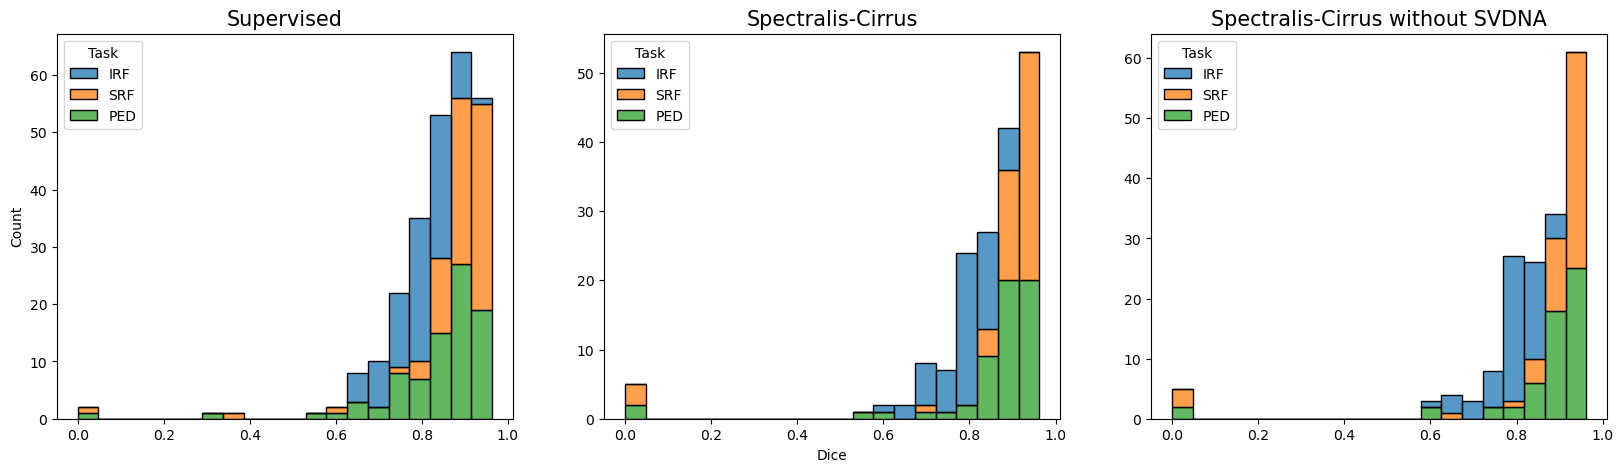

In [20]:
# plot a histogram of F1 in result
fig, ax = plt.subplots(1 , 3, figsize=(20, 5))
sns.histplot(result[result["Model"] == "Supervised-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[0])
ax[0].set_title("Supervised")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[1])
ax[1].set_title("Spectralis-Cirrus")
sns.histplot(result[result["Model"] == "Spectralis-Cirrus-noSVDNA-val"], x="F1", hue="Task", multiple="stack", bins=20, ax=ax[2])
ax[2].set_title("Spectralis-Cirrus without SVDNA")

# remove y axis labels and reduce  title size
for a in ax:
    a.set_ylabel("")
    a.set_xlabel("")
    a.title.set_size(15)
ax[0].set_ylabel("Count")
ax[1].set_xlabel("Dice")

plt.show()

In [14]:
supervised = result[result["Model"] == "Supervised-val"]
x = supervised.groupby(["Task", "Model"]).mean().reset_index()
y = supervised.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
0,Supervised-val,0.836 (0.11)


In [20]:
untrained = result[result["Model"] == "Untrained"]
x = untrained.groupby(["Task", "Model"]).mean().reset_index()
y = untrained.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
0,Untrained,0.003 (0.01)


In [26]:
svdna = result[result["Model"].isin(mean_normal)]
x = svdna.groupby(["Task", "Model"]).mean().reset_index()
y = svdna.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
0,Spectralis-Cirrus-val,0.833 (0.15)
1,Spectralis-Topcon-val,0.826 (0.11)
2,Topcon-Cirrus-val,0.811 (0.13)


In [25]:
no_svdna = result[result["Model"].isin(mean_nosvdna)]
x = no_svdna.groupby(["Task", "Model"]).mean().reset_index()
y = no_svdna.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x


,Model,F1
0,Spectralis-Cirrus-noSVDNA-val,0.837 (0.15)
1,Spectralis-Topcon-noSVDNA-val,0.827 (0.12)
2,Topcon-Cirrus-noSVDNA-val,0.818 (0.13)


In [14]:
single = result[result["Model"].isin(single_domains)]
x = single.groupby(["Task", "Model"]).mean().reset_index()
y = single.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
#x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Task,Model,F1
0,IRF,Cirrus,0.244 (0.35)
1,IRF,Spectralis,0.187 (0.3)
2,IRF,Topcon,0.234 (0.33)
3,PED,Cirrus,0.15 (0.28)
4,PED,Spectralis,0.078 (0.2)
5,PED,Topcon,0.137 (0.26)
6,SRF,Cirrus,0.183 (0.34)
7,SRF,Spectralis,0.101 (0.23)
8,SRF,Topcon,0.16 (0.3)


In [15]:
sup = supervised[["Task", "Model", "F1"]]
svd = svdna[["Task", "Model", "F1"]]



In [17]:
single = result[result["Model"].isin(ablation)]
x = single.groupby(["Task", "Model"]).mean().reset_index()
y = single.groupby(["Task", "Model"]).std().reset_index()

# only get columns Task, Model and F1
y = y[["Task", "Model", "F1"]]
x = x[["Task", "Model", "F1"]]
x = x.groupby(["Model"]).mean(numeric_only=True).reset_index()
y = y.groupby(["Model"]).mean(numeric_only=True).reset_index()

# combine F1 column of x and y like "x (y)"
x["F1"] = x["F1"].round(3).astype(str) + " (" + y["F1"].round(2).astype(str) + ")"
x

,Model,F1
0,Spectralis-Cirrus,0.21 (0.34)
1,Spectralis-Cirrus-HistmatchingOnly,0.211 (0.34)
2,Spectralis-Cirrus-NoiseAdaptOnly,0.182 (0.31)
3,Supervised,0.216 (0.34)
